In [1]:
import pandas as pd 
import wandb
from tqdm import tqdm
import requests
import os
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn import metrics
import matplotlib.pyplot as plt
import scipy.stats as stats
import matplotlib.colors as mcolors

In [2]:
import pandas as pd 
import wandb
from tqdm import tqdm
import requests
import os
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn import metrics

class wandb_results:
    def __init__(self, project_id, wandb_username="eilamshapira"): 
        self.api = wandb.Api(timeout=60)
        self.project_id = project_id
        self.wandb_username = wandb_username

    def get_sweep_results(self, sweep_id, metric="accuracy_all", best_epoch=False, get_servers=False, reset_api=False, read_csv_if_exist=True, save_to_csv=True):
        if reset_api:
            self.reset_api()

        print(f"Download {sweep_id=} data...")
        runs = self.api.sweep(f"{self.wandb_username}/{self.project_id}/{sweep_id}").runs
        n_runs = len(runs)
        path = f"sweeps_csvs/{sweep_id}_{n_runs}.csv"
        if read_csv_if_exist and os.path.exists(path):
            return pd.read_csv(path, index_col=0)
        summary_list, config_list, name_list = [], [], []
        for run in tqdm(runs): 
            summary_list.append(run.summary._json_dict)
            config_list.append(
                {k: v for k,v in run.config.items()
                  if not k.startswith('_')})
            name_list.append(run.name)

        runs_df = pd.DataFrame({
            "summary": summary_list,
            "config": config_list,
            "name": name_list
            })
        config_cols = pd.json_normalize(runs_df['config'])
        config_cols.columns = [f"config_{c}" for c in config_cols.columns]
        summary_cols = pd.json_normalize(runs_df['summary'])
        runs_df = pd.concat([runs_df, config_cols, summary_cols], axis=1)
        runs_df.drop(['config', 'summary'], axis=1, inplace=True)
        hpt = [c for c in config_cols.columns if c not in ["config_seed", "config_run_hash"]]
        if save_to_csv: runs_df.to_csv(path)
        return runs_df
    
    def get_sweeps_results(self, sweeps, metric="accuracy_all", best_epoch=False, get_servers=False,  read_csv_if_exist=True, save_to_csv=True):
        print("Total number of sweeps:", len(sweeps))
        j = pd.concat([self.get_sweep_results(sweep, metric=metric, best_epoch=best_epoch,  get_servers=get_servers, save_to_csv=save_to_csv, read_csv_if_exist=read_csv_if_exist) for sweep in sweeps])
        j = j.reset_index(drop=True)
        return j
    
    def reset_api(self):
        self.api = wandb.Api()

In [3]:
from read_wandb import wandb_results
api = wandb_results("NLP2024_PROJECT_206320772_313510679", wandb_username="shalom_and_amit")

BASE_METRIC = "accuracy_per_mean_user_and_bot"


In [4]:
def result_metric(sweeps, group_name, drop_list=[0], drop_HPT=True, metric=BASE_METRIC, epoch="best"):
    df = api.get_sweeps_results(sweeps, metric=metric)
    df = df.iloc[:, :-40]

    config_cols = [c for c in df.columns if "config_" in c and c!="config_wandb_run_id" and c!="config_online_simulation_size"]
    HPT_cols = ['config_threshold_adjustment']

    if drop_HPT:
        df=df.drop([c for c in HPT_cols if not c in ["config_LLM_SIM_SIZE", "config_seed"]], axis=1)
        HPT_cols = ["config_LLM_SIM_SIZE", "config_seed"]

    # Remove non-numeric columns before computing mean and std
    numeric_cols = df.select_dtypes(include=np.number).columns
    df_numeric = df[numeric_cols]

    grouped = df_numeric.groupby([c for c in HPT_cols if c != "config_seed"])
    mean_df = grouped.mean()
    std_df = grouped.std()
    
    # Re-add non-numeric columns before computing best_col
    for col in config_cols:
        if col not in mean_df.columns:
            mean_df[col] = df[col]

    if epoch=="best":
        best_col = mean_df[[c for c in mean_df.columns if (metric in c and metric[-4:] == c.split("_epoch")[0][-4:])]].idxmax(axis=1)
    else:
        best_col = mean_df[[c for c in mean_df.columns if f"{metric}_epoch{epoch}" in c]].idxmax(axis=1)

    result = grouped.apply(lambda x: x[best_col.loc[x.name]].values)
    means = grouped.apply(lambda x: x[best_col.loc[x.name]].mean())
    stds = grouped.apply(lambda x: x[best_col.loc[x.name]].std())


    df_cols = {'mean': means, 'std': stds, 'values': result.values}
    if epoch == "best": df_cols['epoch'] = best_col.apply(lambda x: int(x.split("epoch")[1]) if "epoch" in x else "last")

    df_cols['CI'] = result.apply(lambda x: bootstrap_ci(x))

    summary_df = pd.DataFrame(df_cols, index=best_col.index)
    for d in drop_list:
        if d in summary_df.index:
            summary_df=summary_df.drop(d)
    if len(summary_df.index.names) == 1:
        return summary_df.rename_axis(group_name)
    else:
        return summary_df

def bootstrap_ci(data, n_bootstrap=1000, ci=0.95):
    bootstrapped_means = []
    for _ in range(n_bootstrap):
        sample = np.random.choice(data, size=len(data), replace=True)
        bootstrapped_means.append(np.mean(sample))
    lower_bound = np.percentile(bootstrapped_means, (1 - ci) / 2 * 100)
    upper_bound = np.percentile(bootstrapped_means, (1 + ci) / 2 * 100)
    return lower_bound, upper_bound


In [5]:
# sweep_results = result_metric(["i0i93frm", "2aqa6u60", "ke66oixu", "9fy0mgup"], "threshold", drop_HPT=False, epoch="best")
sweep_results = result_metric(["i0i93frm"], "threshold", drop_HPT=False, epoch="best")
sweep_results

Total number of sweeps: 1
Download sweep_id='i0i93frm' data...


,mean,std,values,epoch,CI
threshold,,,,,
0.01,0.825596,0.000722,"[0.8248564780995025, 0.8256330162759945, 0.826...",last,"(0.8248564780995024, 0.8262985587222134)"


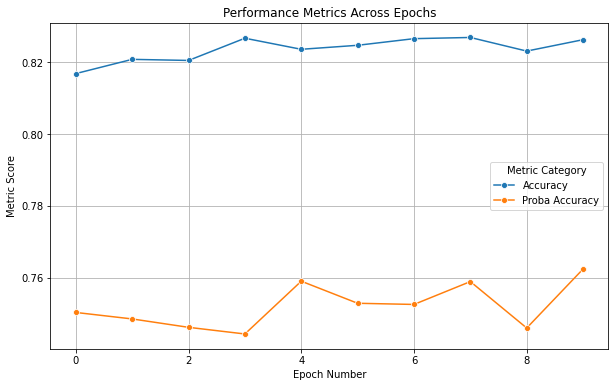

Max score for Accuracy: 0.827 at epoch 8
Max score for Proba Accuracy: 0.762 at epoch 10


In [19]:
# Import the necessary libraries
import wandb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Initialize W&B API connection
api = wandb.Api()

# Retrieve a specific run from W&B
run_id = "shalom_and_amit/NLP2024_PROJECT_206320772_313510679/qo8y8bwi"
run_data = api.run(run_id)

# Extract and inspect summary metrics from the run
summary_metrics = run_data.summary

# Define patterns to extract relevant accuracy metrics
accuracy_pattern = re.compile(r"ENV_Test_accuracy_per_mean_user_and_bot_epoch(\d+)")
probability_pattern = re.compile(r"ENV_Test_proba_accuracy_per_mean_user_and_bot_epoch(\d+)")

# Initialize a list to store the extracted data
metrics_data = []

# Loop through the metrics and match based on the defined patterns
for metric, value in summary_metrics.items():
    accuracy_match = accuracy_pattern.match(metric)
    proba_match = probability_pattern.match(metric)
    
    if accuracy_match:
        epoch_number = int(accuracy_match.group(1))
        metrics_data.append((epoch_number, 'Accuracy', value))
    elif proba_match:
        epoch_number = int(proba_match.group(1))
        metrics_data.append((epoch_number, 'Proba Accuracy', value))

# Create a DataFrame for plotting and analysis
metrics_df = pd.DataFrame(metrics_data, columns=["Epoch", "Metric Type", "Score"])

# Visualize the data with a line plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=metrics_df, x="Epoch", y="Score", hue="Metric Type", marker='o')
plt.xlabel("Epoch Number")
plt.ylabel("Metric Score")
plt.title("Performance Metrics Across Epochs")
plt.grid(True)
plt.legend(title="Metric Category")
plt.show()

# Calculate and print the maximum score for each metric type
for metric_category in metrics_df['Metric Type'].unique():
    filtered_metrics = metrics_df[metrics_df['Metric Type'] == metric_category]
    max_metric = filtered_metrics.loc[filtered_metrics['Score'].idxmax()]
    print(f"Max score for {metric_category}: {max_metric['Score']:.03f} at epoch {max_metric['Epoch']+1}")


In [11]:
sweep_results = result_metric(["0uiqwjmu"], "LLMs", drop_HPT=False, epoch=10)
sweep_results

Total number of sweeps: 1
Download sweep_id='0uiqwjmu' data...


100%|██████████| 3/3 [00:00<00:00, 4567.30it/s]


,mean,std,values,CI
LLMs,,,,
0.01,0.828006,0.002454,"[0.8297416208824178, 0.8262708570552428, nan]","(nan, nan)"


****
ENV_Online Simulation_Probability to choose the right action 0.45951644546416737
****
****
ENV_Online Simulation_Probability to choose the right action_epoch0 0.4579940752207526
****
****
ENV_Online Simulation_Probability to choose the right action_epoch1 0.458541249605681
****
****
ENV_Online Simulation_Probability to choose the right action_epoch10 0.45672177426380506
****
****
ENV_Online Simulation_Probability to choose the right action_epoch11 0.45470230186597294
****
****
ENV_Online Simulation_Probability to choose the right action_epoch12 0.4632159636817065
****
****
ENV_Online Simulation_Probability to choose the right action_epoch13 0.46002507817262733
****
****
ENV_Online Simulation_Probability to choose the right action_epoch14 0.45951644546416737
****
****
ENV_Online Simulation_Probability to choose the right action_epoch2 0.4594781965872211
****
****
ENV_Online Simulation_Probability to choose the right action_epoch3 0.45838064772585446
****
****
ENV_Online Simulation_

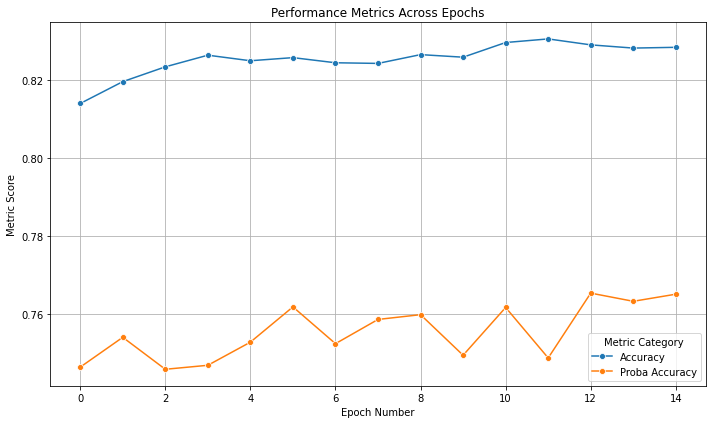

Max score for Accuracy: 0.831 at epoch 12
Max score for Proba Accuracy: 0.765 at epoch 13


In [22]:
# Import the necessary libraries
import wandb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Initialize W&B API connection
api = wandb.Api()

# Retrieve a specific run from W&B
run_id = "shalom_and_amit/NLP2024_PROJECT_206320772_313510679/d4lq93ml"
run_data = api.run(run_id)

# Extract and inspect summary metrics from the run
summary_metrics = run_data.summary

# Define patterns to extract relevant accuracy metrics
accuracy_pattern = re.compile(r"ENV_Test_accuracy_per_mean_user_and_bot_epoch(\d+)")
probability_pattern = re.compile(r"ENV_Test_proba_accuracy_per_mean_user_and_bot_epoch(\d+)")

# Initialize a list to store the extracted data
metrics_data = []

# Loop through the metrics and match based on the defined patterns
for metric, value in summary_metrics.items():
    accuracy_match = accuracy_pattern.match(metric)
    proba_match = probability_pattern.match(metric)
    print("****")
    print(metric, value)
    print("****")
    
    if accuracy_match:
        epoch_number = int(accuracy_match.group(1))
        metrics_data.append((epoch_number, 'Accuracy', value))
    elif proba_match:
        epoch_number = int(proba_match.group(1))
        metrics_data.append((epoch_number, 'Proba Accuracy', value))

# Create a DataFrame for plotting and analysis
metrics_df = pd.DataFrame(metrics_data, columns=["Epoch", "Metric Type", "Score"])

# Visualize the data with a line plot (multiple lines for different metric types)
plt.figure(figsize=(10, 6))
sns.lineplot(data=metrics_df, x="Epoch", y="Score", hue="Metric Type", marker='o')
plt.xlabel("Epoch Number")
plt.ylabel("Metric Score")
plt.title("Performance Metrics Across Epochs")
plt.grid(True)
plt.legend(title="Metric Category")
plt.tight_layout()
plt.show()

# Calculate and print the maximum score for each metric type
for metric_category in metrics_df['Metric Type'].unique():
    filtered_metrics = metrics_df[metrics_df['Metric Type'] == metric_category]
    max_metric = filtered_metrics.loc[filtered_metrics['Score'].idxmax()]
    print(f"Max score for {metric_category}: {max_metric['Score']:.03f} at epoch {max_metric['Epoch']+1}")


# . Plotting Loss Over Epochs

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create a dictionary to organize the data
data = {
    'Epoch': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
    'Probability to Choose Right Action': [
        0.457994, 0.458541, 0.459478, 0.458380, 0.461441, 0.464045, 
        0.459083, 0.459822, 0.458796, 0.457790, 0.456722, 0.454702, 
        0.463216, 0.460025, 0.459516
    ],
    'Right Action': [
        0.457871, 0.458456, 0.459359, 0.458256, 0.461290, 0.463852, 
        0.458898, 0.459424, 0.458608, 0.457627, 0.456405, 0.454409, 
        0.462919, 0.459425, 0.459029
    ],
    'Total Loss': [
        11.4096, 3.9342, 3.9485, 5.2250, 5.2685, 6.4886, 
        5.2549, 6.5037, 5.8413, 4.7140, 6.1170, 7.9697, 
        8.9380, 7.2359, 8.4817
    ]
}

# Convert to a DataFrame
df = pd.DataFrame(data)

# Display the DataFrame to ensure the data is correctly organized
df


,Epoch,Probability to Choose Right Action,Right Action,Total Loss
0,0,0.457994,0.457871,11.4096
1,1,0.458541,0.458456,3.9342
2,2,0.459478,0.459359,3.9485
3,3,0.458380,0.458256,5.2250
4,4,0.461441,0.461290,5.2685
5,5,0.464045,0.463852,6.4886
6,6,0.459083,0.458898,5.2549
7,7,0.459822,0.459424,6.5037
8,8,0.458796,0.458608,5.8413
9,9,0.457790,0.457627,4.7140


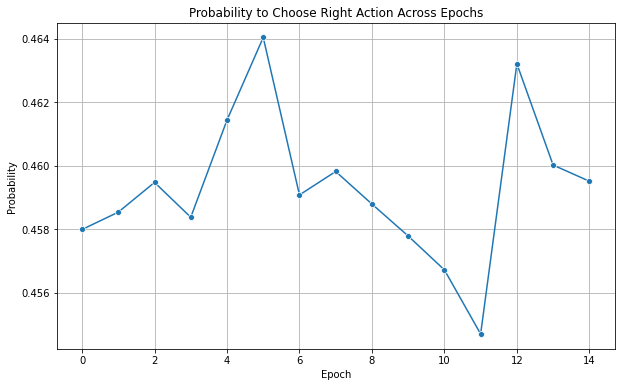

In [25]:
# Plot: Probability to Choose Right Action Across Epochs
plt.figure(figsize=(10, 6))
sns.lineplot(x='Epoch', y='Probability to Choose Right Action', data=df, marker='o')
plt.title("Probability to Choose Right Action Across Epochs")
plt.xlabel("Epoch")
plt.ylabel("Probability")
plt.grid(True)
plt.show()


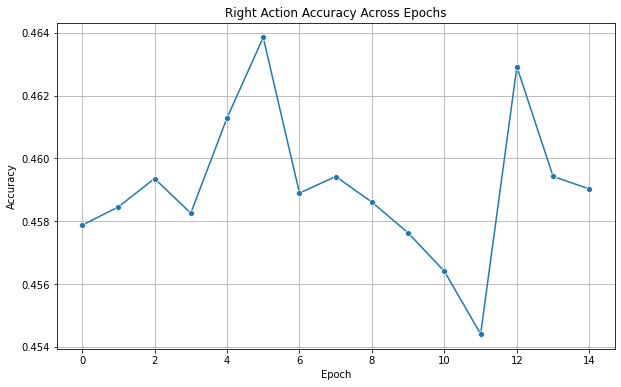

In [26]:
# Plot: Right Action Across Epochs
plt.figure(figsize=(10, 6))
sns.lineplot(x='Epoch', y='Right Action', data=df, marker='o')
plt.title("Right Action Accuracy Across Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()


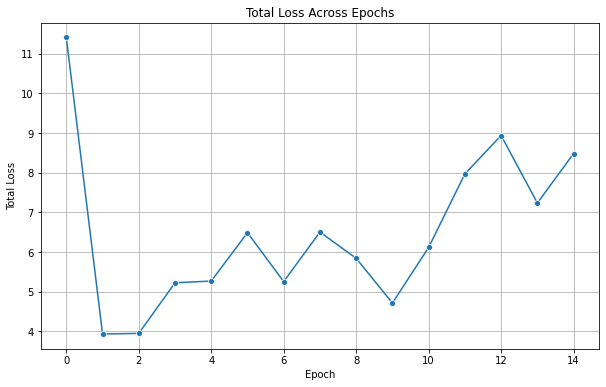

In [27]:
# Plot: Total Loss Across Epochs
plt.figure(figsize=(10, 6))
sns.lineplot(x='Epoch', y='Total Loss', data=df, marker='o')
plt.title("Total Loss Across Epochs")
plt.xlabel("Epoch")
plt.ylabel("Total Loss")
plt.grid(True)
plt.show()


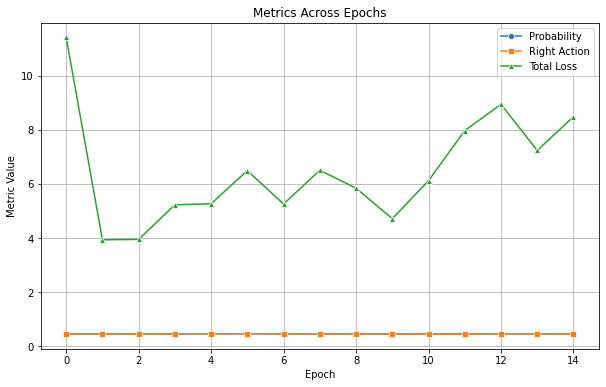

In [28]:
# Combined Plot: Probability, Right Action, and Total Loss Across Epochs
plt.figure(figsize=(10, 6))
sns.lineplot(x='Epoch', y='Probability to Choose Right Action', data=df, marker='o', label='Probability')
sns.lineplot(x='Epoch', y='Right Action', data=df, marker='s', label='Right Action')
sns.lineplot(x='Epoch', y='Total Loss', data=df, marker='^', label='Total Loss')
plt.title("Metrics Across Epochs")
plt.xlabel("Epoch")
plt.ylabel("Metric Value")
plt.legend()
plt.grid(True)
plt.show()


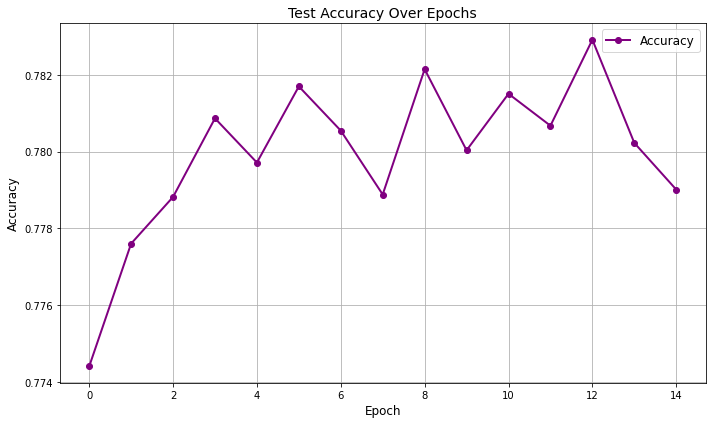

In [34]:
import matplotlib.pyplot as plt
import re

# Initialize W&B API connection
api = wandb.Api()

# Retrieve a specific run from W&B
run_id = "shalom_and_amit/NLP2024_PROJECT_206320772_313510679/d4lq93ml"
run_data = api.run(run_id)

# Extract and inspect summary metrics from the run
summary_metrics = run_data.summary

# Define patterns to match accuracy epochs
accuracy_pattern = re.compile(r"ENV_Test_accuracy_epoch(\d+)")

# Initialize lists for epochs and accuracies
epochs = []
accuracies = []

# Extract the accuracy data
for metric, value in summary_metrics.items():
    match = accuracy_pattern.match(metric)
    if match:
        epoch = int(match.group(1))
        epochs.append(epoch)
        accuracies.append(float(value))

# Ensure epochs and accuracies are sorted by epoch number
epochs, accuracies = zip(*sorted(zip(epochs, accuracies)))

# Plot the accuracy over epochs with improved styling
plt.figure(figsize=(10, 6))
plt.plot(epochs, accuracies, marker='o', linestyle='-', color='purple', label='Accuracy', linewidth=2)
plt.title('Test Accuracy Over Epochs', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.grid(True)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()
